In [1]:
# Import the Required Packages
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, Callback
from tensorflow.keras.callbacks import EarlyStopping

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import csv
import os

## Step 1: Data Loading

In [2]:
train_dir = os.path.join(os.getcwd(), 'train')
test_dir = os.path.join(os.getcwd(), 'test')
validation_dir = os.path.join(os.getcwd(), 'validation')

### Mobilenet PRETRAIN MODEL Base

In [3]:

img_size = 224

mobilenet_base = keras.applications.mobilenet_v2.MobileNetV2(weights='imagenet',
                                                             include_top=False,
                                                             input_shape=(img_size, img_size, 3))

In [4]:
mobilenet_base.summary() 

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

### Feature extraction without data augmentation With MobileNet

In [5]:
# features shape need to follow model last layer
# Need to add a comma and 10 for labels shape as there are 10 classes for the dataset

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 32

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 7, 7, 1280))
    labels = np.zeros(shape=(sample_count,10))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(img_size, img_size),
        batch_size=batch_size,
        class_mode='categorical')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = mobilenet_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
    return features, labels

In [6]:
train_features, train_labels = extract_features(train_dir, 7500)
validation_features, validation_labels = extract_features(validation_dir, 2000)
test_features, test_labels = extract_features(test_dir, 500)

Found 7500 images belonging to 10 classes.
1/1 [==============================] - 1s 600ms/step
Found 2000 images belonging to 10 classes.
1/1 [==============================] - 0s 33ms/step
Found 500 images belonging to 10 classes.
1/1 [==============================] - 0s 34ms/step


In [7]:
print(train_features.shape)
print(train_labels.shape)

(7500, 7, 7, 1280)
(7500, 10)


In [8]:
train_features = np.reshape(train_features, (7500, 7 * 7 * 1280))
validation_features = np.reshape(validation_features, (2000, 7 * 7 * 1280))
test_features = np.reshape(test_features, (500, 7 * 7 * 1280))

### MobileNet Model 

In [9]:
mobilenet_base.trainable = False

mobilenet_1 = models.Sequential()
mobilenet_1.add(layers.Dense(256, activation='relu', input_shape=(7 * 7 * 1280,)))
mobilenet_1.add(layers.Dense(10, activation='softmax'))

mobilenet_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               16056576  
                                                                 
 dense_1 (Dense)             (None, 10)                2570      
                                                                 
Total params: 16,059,146
Trainable params: 16,059,146
Non-trainable params: 0
_________________________________________________________________


In [10]:
mobilenet_1.compile(optimizer=optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['acc'])

In [11]:
# Train the Model
from keras.callbacks import ModelCheckpoint

# Checkpoint
mc = ModelCheckpoint(
    'mobilenet_no_augmentation.keras',
    monitor='val_loss',
    mode='min',
    verbose=1,
    save_best_only=True
)


history = mobilenet_1.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=32,
                    callbacks=[mc],
                    validation_data=(validation_features, validation_labels))

Epoch 1/30
231/235 [============================>.] - ETA: 0s - loss: 1.7658 - acc: 0.6813
Epoch 1: val_loss improved from inf to 0.97316, saving model to mobilenet_no_augmentation.keras
235/235 [==============================] - 3s 13ms/step - loss: 1.7548 - acc: 0.6820 - val_loss: 0.9732 - val_acc: 0.7270
Epoch 2/30
230/235 [============================>.] - ETA: 0s - loss: 0.2880 - acc: 0.9026
Epoch 2: val_loss improved from 0.97316 to 0.89323, saving model to mobilenet_no_augmentation.keras
235/235 [==============================] - 2s 10ms/step - loss: 0.2895 - acc: 0.9019 - val_loss: 0.8932 - val_acc: 0.7700
Epoch 3/30
234/235 [============================>.] - ETA: 0s - loss: 0.0881 - acc: 0.9722
Epoch 3: val_loss did not improve from 0.89323
235/235 [==============================] - 2s 9ms/step - loss: 0.0885 - acc: 0.9721 - val_loss: 0.9460 - val_acc: 0.7875
Epoch 4/30
230/235 [============================>.] - ETA: 0s - loss: 0.0374 - acc: 0.9893
Epoch 4: val_loss did not im

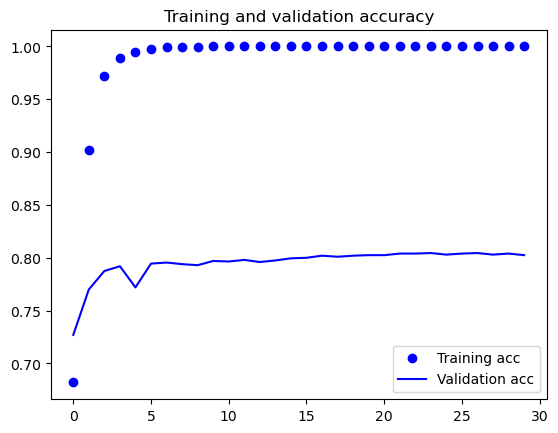

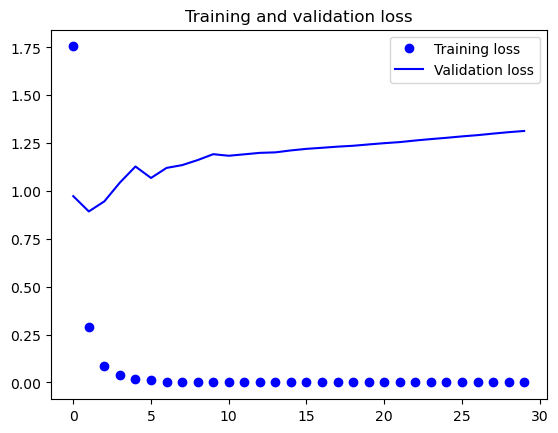

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()